In [2]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Pastel2.colors)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# design reverse integrability

In [51]:
path="./simulations/"
fnames=os.listdir("./simulations/")
fnames = [f for f in fnames if f.endswith('.hdf5') ]
fname = fnames[3]
myfile = h5py.File(path+fname, 'r')
GCname = myfile.attrs['GCname']

In [ ]:
streaminitial = myfile['streaminitial'][:]
hostorbit=myfile["hostorbit"][:]
hosttimestamps = myfile["timestamps"][:]
hostparams = myfile.attrs["hostparams"]
inithostperturber = [hosttimestamps, *hostorbit, *hostparams]
integrationparameters = myfile.attrs["integrationparameters"]
staticgalaxy=[myfile.attrs['potentialname'], myfile.attrs['potentialparams']]
streamfinal=myfile['streamfinal'][:]
args = [streamfinal, staticgalaxy, integrationparameters, inithostperturber]
stream_retrace, tesc, timestamps_retrace, comptime = STR.leapfrogtofinalpositions_stream_retrace(args)
print(streaminitial.shape)
# shift to where it should be 
streaminitial = streaminitial + hostorbit[:,0][:,np.newaxis]

(6, 735)


In [89]:
dt = integrationparameters[1]
tau=np.sqrt(hostparams[2]**3/(hostparams[0]*hostparams[1]))
alpha = dt/tau
alpha
# Calculate the number of timesteps per dynamical time
n_steps_per_tau = tau / dt

# Format alpha (dt/tau) in scientific notation
mantissa =  10**(int(np.floor(np.log10(abs(alpha)))))
exponent = int(np.floor(np.log10(abs(alpha))))
alpha_formatted = r"${:.1f} \times 10^{{{}}}$".format(mantissa*10, exponent-1)

print(f"Timestep: dt = {dt}")
print(f"Dynamical time: τ = {tau:.5f}")
print(f"Number of steps per dynamical time: {n_steps_per_tau:.1f}")
print(f"Ratio dt/τ = {alpha_formatted}")

boost = 1
matissa = 10**(np.log10(alpha) - int(np.log10(alpha)) + boost)
exponent = int(np.log10(alpha)) - boost
alpha_formatted = r"$\Delta t = {:.1f} \times 10^{{{}}} \tau$".format(matissa, exponent)
print(f"Boosted ratio dt/τ = {alpha_formatted}")
text_comp_time = r"$\mathrm{{Comp~time}} = {:.2f}~\mathrm{{s}}$".format(comptime)
integrationtime=integrationparameters[-1]*integrationparameters[1]
NSTEPS = int(integrationparameters[-1])
integrationtime=integrationtime*(u.s * (u.kpc/u.km))
integrationtime = integrationtime.to(u.Myr)
text_integration_time = r"$\mathrm{{T}} = {:.0f}~\mathrm{{Myr}}$".format(integrationtime.value)
print(text_comp_time)
print(text_integration_time)
image_name = "NumericalErrorStreamRetrace_{:s}_Nsteps_{:d}_stepsPerTau_{:d}.png".format(GCname, NSTEPS, int(n_steps_per_tau))

Timestep: dt = 0.00048828125
Dynamical time: τ = 0.01284
Number of steps per dynamical time: 26.3
Ratio dt/τ = $0.1 \times 10^{-3}$
Boosted ratio dt/τ = $\Delta t = 3.8 \times 10^{-2} \tau$
$\mathrm{Comp~time} = 2.94~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$


In [5]:
_,_,_,phiMW = tstrippy.potentials.pouliasis2017pii(staticgalaxy[1],stream_retrace[0], stream_retrace[1], stream_retrace[2],)
T = 0.5 * (stream_retrace[3]**2 + stream_retrace[4]**2 + stream_retrace[5]**2) 
dx,dy,dz = stream_retrace[0] - hostorbit[0][0], stream_retrace[1] - hostorbit[0][1], stream_retrace[2] - hostorbit[0][2]
_,_,_,phiGC = tstrippy.potentials.plummer(hostparams, dx, dy, dz)
EF = T + phiMW + phiGC

In [6]:
_,_,_,phiMW = tstrippy.potentials.pouliasis2017pii(staticgalaxy[1],streaminitial[0], streaminitial[1], streaminitial[2],)
T = 0.5 * (streaminitial[3]**2 + streaminitial[4]**2 + streaminitial[5]**2)
dx,dy,dz = streaminitial[0] - hostorbit[0][0], streaminitial[1] - hostorbit[0][1], streaminitial[2] - hostorbit[0][2]
_,_,_,phiGC = tstrippy.potentials.plummer(hostparams, dx, dy, dz)
E0 = T + phiMW + phiGC

In [7]:
_,_,_,phiMW = tstrippy.potentials.pouliasis2017pii(staticgalaxy[1],stream_retrace[0], stream_retrace[1], stream_retrace[2],)
T = 0.5 * (stream_retrace[3]**2 + stream_retrace[4]**2 + stream_retrace[5]**2) 
dx,dy,dz = stream_retrace[0] - hostorbit[0][0], stream_retrace[1] - hostorbit[0][1], stream_retrace[2] - hostorbit[0][2]
_,_,_,phiGC = tstrippy.potentials.plummer(hostparams, dx, dy, dz)
Eretrace = T + phiMW + phiGC

In [8]:
errEF=np.abs((EF - E0) / E0)
errER = np.abs((Eretrace - E0) / E0)

In [9]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Accent.colors)

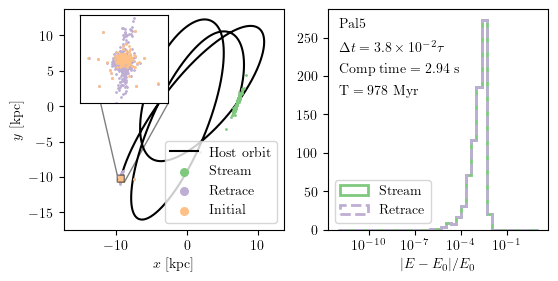

In [102]:
# fig,axis= plt.subplots(1,1,figsize=((8.25-2),(8.25-2)/2))
fig = plt.figure(figsize=(8.25-2, 4.5))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
axis = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], )
axis.plot(hostorbit[0,6:], hostorbit[1,6:], 'k-', label='Host orbit',zorder=0)
scatStream=axis.scatter(streamfinal[0], streamfinal[1], s=1, label='Stream')
scatRetrace=axis.scatter(stream_retrace[0], stream_retrace[1], s=1, label='Retrace')
scatInit=axis.scatter(streaminitial[0],  streaminitial[1], s=1,  label='Initial')
# Also make markers in the inset legend bigger if needed
xymin = np.min([axis.get_xlim()[0], axis.get_ylim()[0]])
xymax = np.max([axis.get_xlim()[1], axis.get_ylim()[1]])
axis.set_xlim(xymin, xymax)
axis.set_ylim(xymin, xymax)

# add a subplot that zooms on the retrace positions
axins = axis.inset_axes([0.075, 0.575, 0.4, 0.4])  # [x0, y0, width, height]
axins.scatter(stream_retrace[0], stream_retrace[1], s=1, c=scatRetrace.get_edgecolor(), label='Stream retrace positions')
axins.scatter(streaminitial[0],   streaminitial[1], s=1, c=scatInit.get_edgecolor(), label='Stream initial positions')
axins.set_aspect('equal', adjustable='box')
# Add indicator lines from the main plot to the inset
axis.indicate_inset_zoom(axins, edgecolor="black")
# only do a couple characteristic radii
radius = .5
axins.set_xlim(hostorbit[0,0] + - radius, hostorbit[0,0]  + radius)
axins.set_ylim(hostorbit[1,0] + - radius, hostorbit[1,0]  + radius)
axins.set_xticks([])
axins.set_yticks([])

# Make markers in legend bigger
axis.legend(loc='lower right')
axis.set_aspect('equal', )
axis.set_xlabel(r'$x$ [kpc]')
axis.set_ylabel(r'$y$ [kpc]')
legend = axis.legend(loc='lower right')
for handle in legend.legend_handles:
    handle._sizes = [30]


bins = np.logspace(-12,1,40)
ax2.hist(errEF,bins=bins, histtype='step', color=scatStream.get_facecolor(), lw=2, label='Stream', linestyle='-');
ax2.hist(errER,bins=bins, histtype='step', color=scatRetrace.get_facecolor(), lw=2, label='Retrace', linestyle='--');
ax2.set_xscale('log')

ax2.set_xlabel(r'$|E - E_0| / E_0$')
ax2.legend()

# Make sure ax2 has the same height as axis
ax2.set_position([ax2.get_position().x0, 
                 axis.get_position().y0, 
                 ax2.get_position().width, 
                 axis.get_position().height])
ax2.text(0.05, 0.9, r"$\mathrm{{{:s}}}$".format(GCname), transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.8, alpha_formatted, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.7, text_comp_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.6, text_integration_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
fig.savefig("../../images/"+image_name, bbox_inches='tight', dpi=300)

In [161]:
# pseduo code

# slip the sign of the velocities for the host when we change directions 

# no need to reorient the array becuase the new func to coordinate the indicies is good

# no need to flip the sign of the velocities for the stream, setbackwardorbit does that

# so load in the orbit

# take the integration parameters

# load in the stream particles at the end

# integrate backward and see where we land 

In [91]:
NSTEP = int(1e6)
NP = int(1e5)
Nc = 80e-9
Nmc = 50
NGC = 165
comptime=Nmc*NGC*NSTEP*NP*Nc * u.s
comptime.to(u.day) / 100

<Quantity 7.63888889 d>

# Computation time

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$


In [92]:
import os 
targetGC = 'NGC6760'
integrationtime = 1  # in dynamical time units
NPs = np.logspace(1,3,3, dtype=int)  # number of particles for the stream
alphas = np.logspace(1,-2,3)
Nc = 80e-9 # mean time per single step 

In [93]:
path="./simulations/"
fnames=os.listdir("./simulations/")
fnames = [f for f in fnames if f.endswith('.hdf5') ]
NPs = [ ]
NSTEPS = []
comp = []
for i in range(0,len(fnames)):
    myfile=h5py.File(path+fnames[i], 'r')
    NSTEP = myfile['hostorbit'].shape[1]
    NP = myfile['streamfinal'].shape[1]
    comptimestream = myfile['comptimestream'][()]

    NPs.append(NP)
    NSTEPS.append(NSTEP)
    comp.append(comptimestream)

NPs = np.array(NPs)
NSTEPS = np.array(NSTEPS)
comp = np.array(comp)

In [94]:
np.mean(comp/NPs/NSTEPS)

np.float64(4.459246713536144e-06)

In [95]:
logNPS = np.log10(NPs)
logNSTEPS = np.log10(NSTEPS)
logcomp = np.log10(comp)

In [96]:
A = np.vstack([np.ones_like(logNPS), logNPS, logNSTEPS]).T
coeffs, residuals, rank, s = np.linalg.lstsq(A, logcomp, rcond=None)
logA, alpha, beta = coeffs

# Estimate variance of residuals
n = len(logcomp)
p = A.shape[1]
res_var = residuals[0] / (n - p) if residuals.size > 0 else 0

# Covariance matrix of coefficients
cov = res_var * np.linalg.inv(A.T @ A)
errors = np.sqrt(np.diag(cov))

logA_err, alpha_err, beta_err = errors

print(f"Fit: log C = {logA:.2f} ± {logA_err:.2f} + {alpha:.2f} ± {alpha_err:.2f} log Np + {beta:.2f} ± {beta_err:.2f} log Nsteps")
print(f"Fit: C = 10^{logA:.2f} ± {logA_err:.2f} * Np^{alpha:.2f} ± {alpha_err:.2f} * Nsteps^{beta:.2f} ± {beta_err:.2f}")


Fit: log C = -6.98 ± 0.22 + 1.49 ± 0.07 log Np + 1.00 ± 0.04 log Nsteps
Fit: C = 10^-6.98 ± 0.22 * Np^1.49 ± 0.07 * Nsteps^1.00 ± 0.04


In [97]:
print(f"Fit: log C = {logA:.2f} + {alpha:.2f} log Np + {beta:.2f} log Nsteps")
print(f"Fit: C = 10^{logA:.2f} * Np^{alpha:.2f} * Nsteps^{beta:.2f}")

Fit: log C = -6.98 + 1.49 log Np + 1.00 log Nsteps
Fit: C = 10^-6.98 * Np^1.49 * Nsteps^1.00


In [98]:
cmax = np.max(comp)
cmin = np.min(comp)
norm = mpl.colors.LogNorm(vmin=cmin, vmax=cmax)
cmap = mpl.cm.rainbow
colors = cmap(norm(comp))

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_4476/1490778462.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(NSTEPS, NPs, c=colors, marker="s", s=100, cmap='viridis', alpha=0.7)


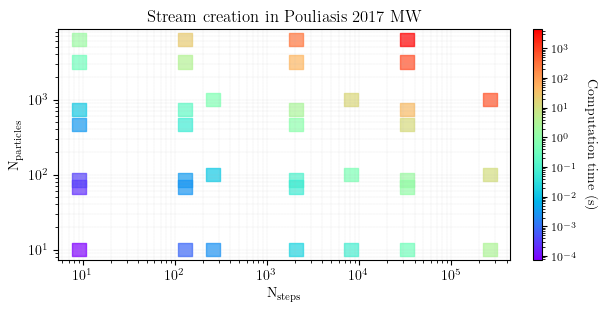

In [99]:
fig=plt.figure(figsize=(8.25-2,3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1/50],hspace=0.1, wspace=0.1)
axis = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])
axis.grid(True, which='both', linestyle='--', linewidth=0.1)
axis.scatter(NSTEPS, NPs, c=colors, marker="s", s=100, cmap='viridis', alpha=0.7)
axis.set_xlabel(r'$\mathrm{N}_{\mathrm{steps}}$')
axis.set_ylabel(r'$\mathrm{N}_{\mathrm{particles}}$')
axis.set_title(r'$\mathrm{Stream~creation~in~Pouliasis~2017~MW}$')
axis.set_xscale('log')
axis.set_yscale('log')
# axis.set_aspect('equal')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mathrm{Computation~time~(s)}$', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=8)
# make the colorbar the same height as the plot
# Adjust colorbar position to match plot height
cbar.ax.set_position([cbar.ax.get_position().x0, 
                     axis.get_position().y0, 
                     cbar.ax.get_position().width, 
                     axis.get_position().height])

In [69]:
NPs.max()

np.int64(3162)